In [1]:
import jax
import matplotlib.pyplot as plt
import numpy as np
from models import CatCNOT, CrossResonanceGate, DrivenCavity


def is_gpu_available() -> bool:
    return any('cuda' in str(device) for device in jax.devices())


CPU_MODEL = 'AMD Ryzen 7 7700X 8-Core Processor'
GPU_MODEL = 'NVIDIA GeForce RTX 4090'

## Benchmark all models with fixed Hilbert space size

In [2]:
# init models
models = [DrivenCavity(), CrossResonanceGate(), CatCNOT()]

# compute speedups for each model
speedups = []
for model in models:
    print(f'Running benchmark for {model.__class__.__name__}')  # noqa: T201

    # check qutip and dynamiqs models are equal
    model.check_args()

    # benchmark models
    timer_qutip_cpu = model.benchmark('qutip', 'cpu')
    timer_dynamiqs_cpu = model.benchmark('dynamiqs', 'cpu')
    if is_gpu_available():
        timer_dynamiqs_gpu = model.benchmark('dynamiqs', 'gpu')

    # store results
    speedup_cpu = timer_qutip_cpu / timer_dynamiqs_cpu
    if is_gpu_available():
        speedup_gpu = timer_qutip_cpu / timer_dynamiqs_gpu
        speedups.append((1.0, speedup_cpu, speedup_gpu))
    else:
        speedups.append((1.0, speedup_cpu))

Running benchmark for DrivenCavity
Running benchmark for CrossResonanceGate
Running benchmark for CatCNOT


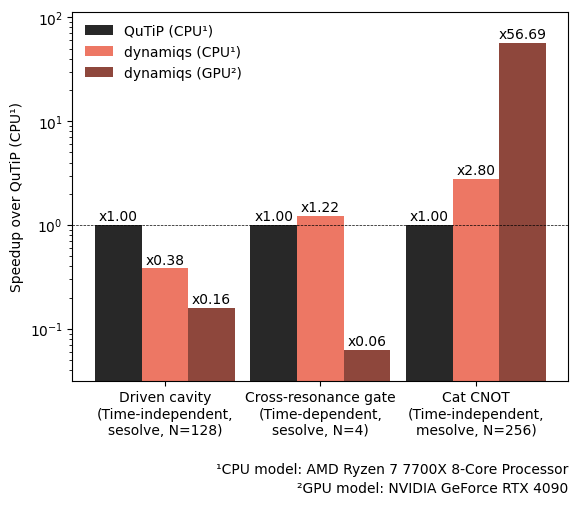

In [25]:
# prepare plot formatting
model_labels = [
    'Driven cavity\n(Time-independent,\nsesolve, N=128)',
    'Cross-resonance gate\n(Time-dependent,\nsesolve, N=4)',
    'Cat CNOT\n(Time-independent,\nmesolve, N=256)',
]
groups = np.arange(len(models))
if is_gpu_available():
    labels = ['QuTiP (CPU¹)', 'dynamiqs (CPU¹)', 'dynamiqs (GPU²)']
    colors = ['#282828', '#ed7764', '#8e473c']
    width = 0.3
else:
    labels = ['QuTiP (CPU¹)', 'dynamiqs (CPU¹)']
    colors = ['#282828', '#ed7764']
    width = 0.45

# create plot
fig, ax = plt.subplots()
ax.axhline(1.0, 0, len(models), color='k', linestyle='--', lw=0.5)

for i, (label, color) in enumerate(zip(labels, colors)):
    offset = i * width
    speedup = [speedup[i] for speedup in speedups]
    rects = ax.bar(groups + offset, speedup, width, color=color, label=label)
    ax.bar_label(rects, padding=1, fmt='x%.2f')

ax.legend(frameon=False, loc='upper left')
ax.set_ylabel('Speedup over QuTiP (CPU¹)')
ax.set_xticks(groups + 0.5 * (len(labels) - 1) * width, model_labels)
ax.set_yscale('log')
ax.set_ylim((0.5 * np.min(speedups), 2 * np.max(speedups)))
ax.annotate(
    f'¹CPU model: {CPU_MODEL}',
    (0, 0),
    (1, -0.22),
    xycoords='axes fraction',
    textcoords='axes fraction',
    va='top',
    ha='right',
)
if is_gpu_available():
    ax.annotate(
        f'²GPU model: {GPU_MODEL}',
        (0, 0),
        (1, -0.27),
        xycoords='axes fraction',
        textcoords='axes fraction',
        va='top',
        ha='right',
    )
plt.show()

## Sweep Hilbert space size on a single model

In [26]:
model_class = DrivenCavity
sizes = 2 ** np.arange(4, 11, dtype=int)
timers = []

for N in sizes:
    print(f'Running benchmark for N={N}')  # noqa: T201

    # init model
    model = model_class(N=int(N))

    # check qutip and dynamiqs models are equal
    model.check_args()

    # benchmark models
    timer_qutip_cpu = model.benchmark('qutip', 'cpu')
    timer_dynamiqs_cpu = model.benchmark('dynamiqs', 'cpu')
    if is_gpu_available():
        timer_dynamiqs_gpu = model.benchmark('dynamiqs', 'gpu')

    # store results
    if is_gpu_available():
        timers.append([timer_qutip_cpu, timer_dynamiqs_cpu, timer_dynamiqs_gpu])
    else:
        timers.append([timer_qutip_cpu, timer_dynamiqs_cpu])

timers = np.asarray(timers)

Running benchmark for N=16
Running benchmark for N=32
Running benchmark for N=64
Running benchmark for N=128
Running benchmark for N=256
Running benchmark for N=512
Running benchmark for N=1024


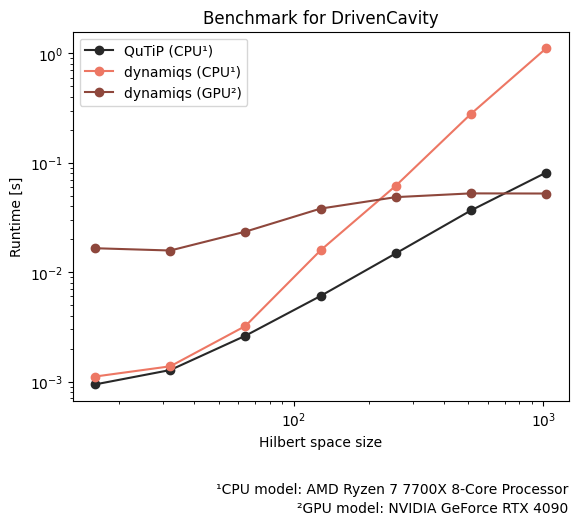

In [27]:
# prepare plot formatting
if is_gpu_available():
    labels = ['QuTiP (CPU¹)', 'dynamiqs (CPU¹)', 'dynamiqs (GPU²)']
    colors = ['#282828', '#ed7764', '#8e473c']
else:
    labels = ['QuTiP (CPU¹)', 'dynamiqs (CPU¹)']
    colors = ['#282828', '#ed7764']

# create plot
fig, ax = plt.subplots()
for i, (label, color) in enumerate(zip(labels, colors)):
    ax.plot(sizes, timers[:, i], 'o-', label=label, color=color)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Hilbert space size')
ax.set_title(f'Benchmark for {model_class.__name__}')
ax.legend()
ax.annotate(
    f'¹CPU model: {CPU_MODEL}',
    (0, 0),
    (1, -0.22),
    xycoords='axes fraction',
    textcoords='axes fraction',
    va='top',
    ha='right',
)
if is_gpu_available():
    ax.annotate(
        f'²GPU model: {GPU_MODEL}',
        (0, 0),
        (1, -0.27),
        xycoords='axes fraction',
        textcoords='axes fraction',
        va='top',
        ha='right',
    )
plt.show()